In [2]:
# Zimportowanie bibliotek
library(arules)
library(tidyverse)
library(kohonen)

Warning message:
"package 'arules' was built under R version 4.4.2"
Loading required package: Matrix


Attaching package: 'arules'


The following objects are masked from 'package:base':

    abbreviate, write


Warning message:
"package 'tidyverse' was built under R version 4.4.2"
Warning message:
"package 'readr' was built under R version 4.4.2"
Warning message:
"package 'dplyr' was built under R version 4.4.2"
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::expand() masks Matrix::expand()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ tidyr::pack()   masks Matrix::pack()
✖ dplyr::recode() masks arules::recode()
✖ tidyr::unpack() masks Matrix::unpack()

In [3]:
# Ustalenie ziarna losowości
set.seed(1234)

In [4]:
# Zaimportowanie zbioru transakcji
groceries <- read.transactions("http://jolej.linuxpl.info/groceries.csv", sep = ",")

In [5]:
# Przekształcenie transakcji na macierz binarną (TRUE/FALSE -> 1/0)
groceries_matrix <- 1 * as(groceries, "matrix")

In [6]:
#####################################################################
# Model niesuperwizowany – budowa SOM i klasteryzacja na 6 klastrów #
#####################################################################

In [7]:
# Utworzenie siatki SOM – 10x10 węzłów, topologia heksagonalna
groceries_grid <- somgrid(xdim = 10, ydim = 10, topo = "hexagonal")

In [8]:
# Trenowanie modelu niesuperwizowanego SOM na pełnym zbiorze
groceries_som <- som(groceries_matrix, grid = groceries_grid, 
                     rlen = 100, alpha = c(0.05, 0.01))

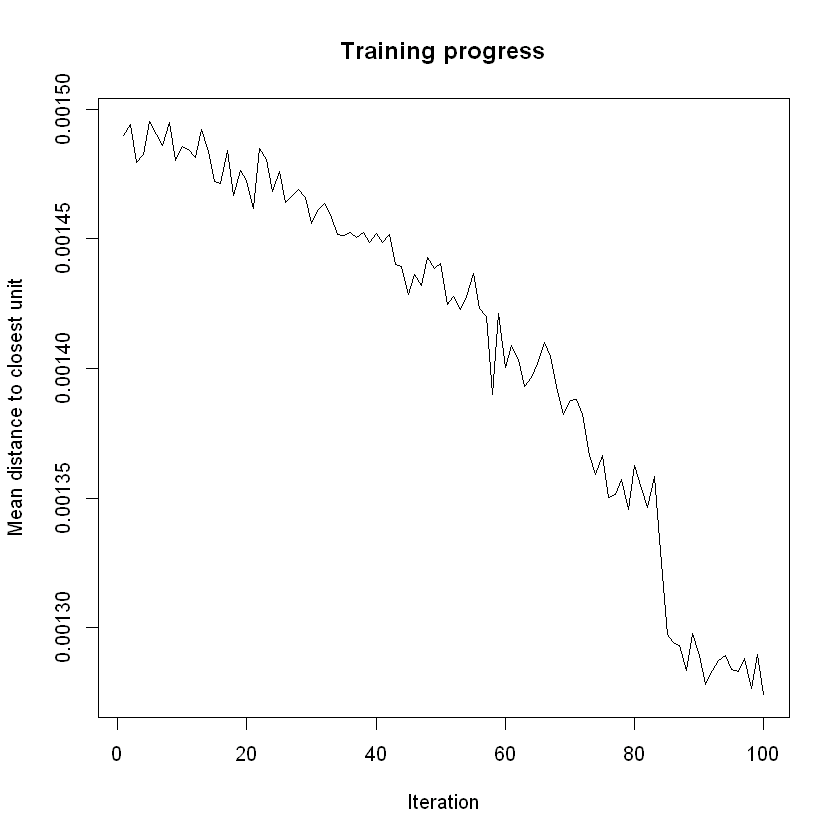

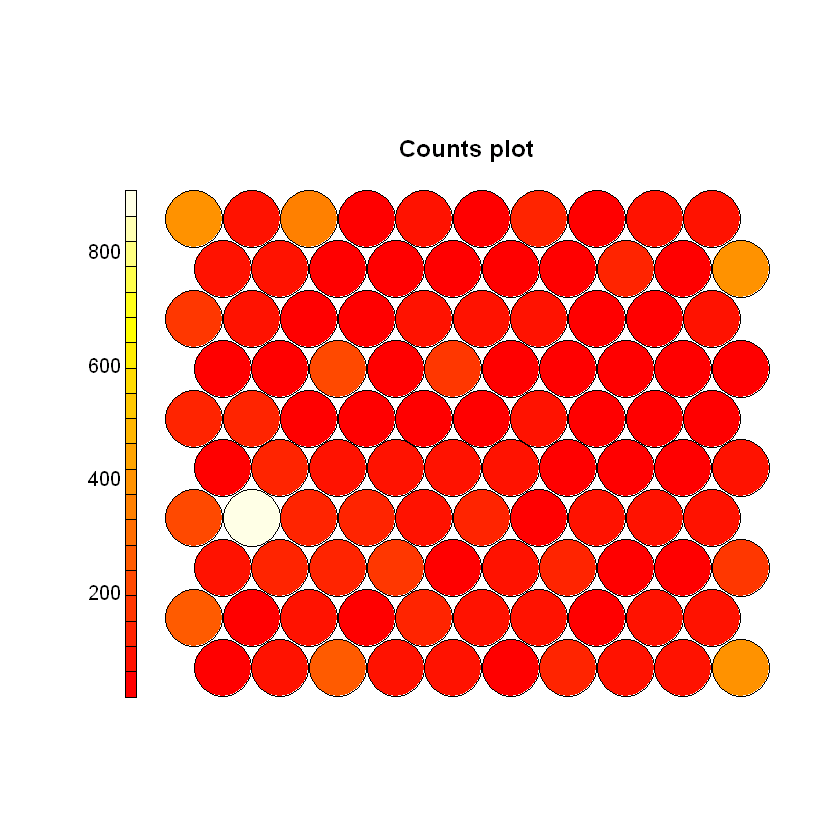

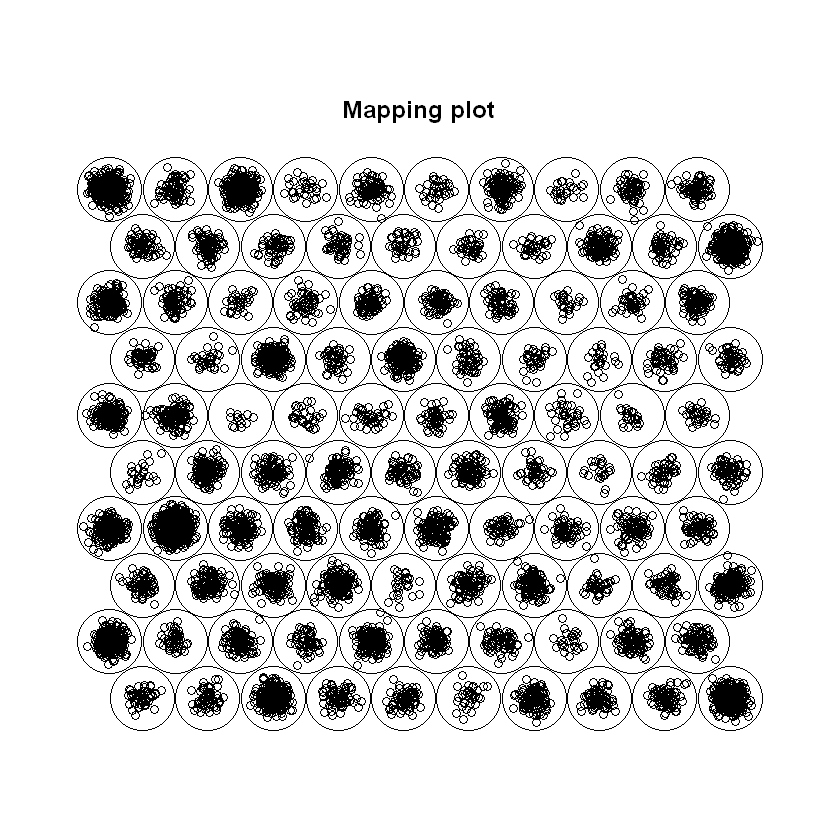

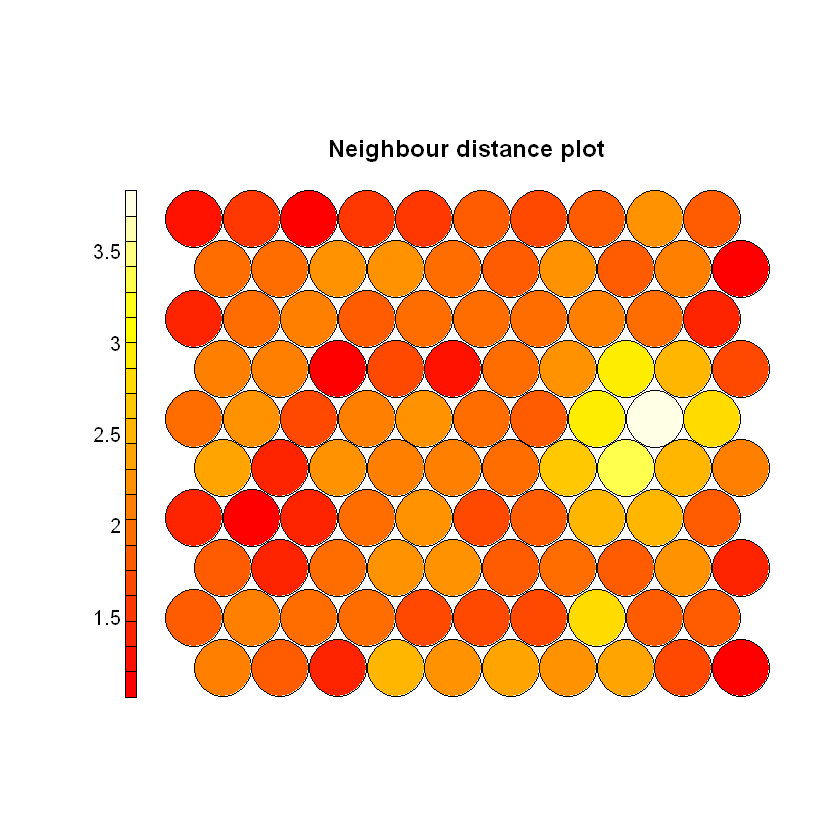

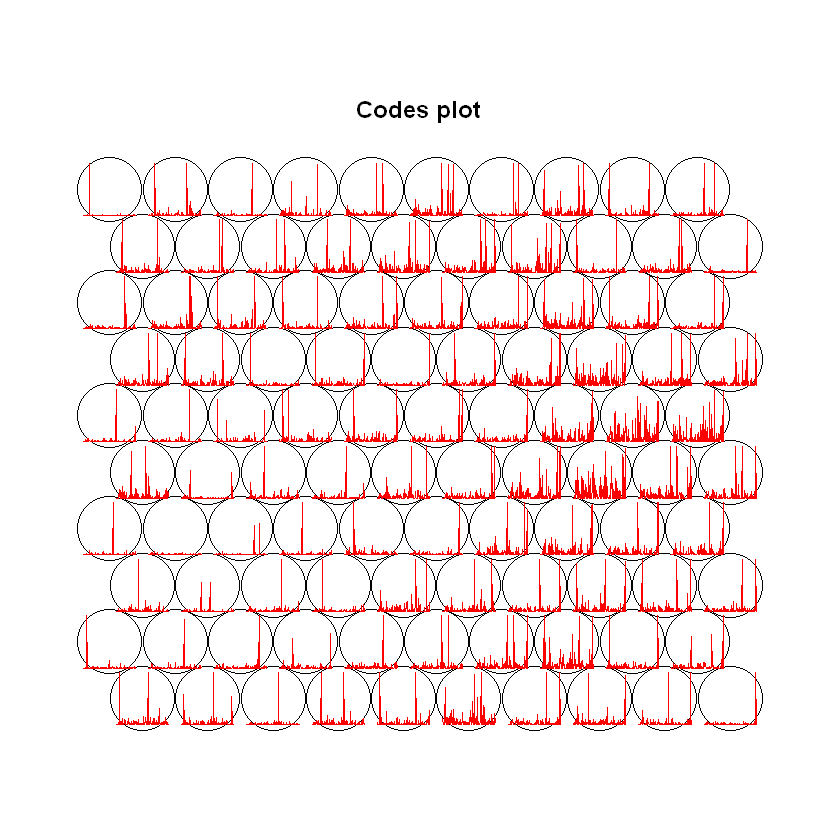

In [9]:
# Wizualizacje
plot(groceries_som, type = "changes")
plot(groceries_som, type = "count")
plot(groceries_som, type = "mapping")
plot(groceries_som, type = "dist.neighbours")
plot(groceries_som, type = "codes")

In [10]:
# Klasteryzacja hierarchiczna kodów neuronów – ustalamy 6 klastrów
groups <- 6
som_codes <- groceries_som$codes[[1]]
hc_groceries <- hclust(dist(som_codes))
clusters_groceries <- cutree(hc_groceries, k = groups)

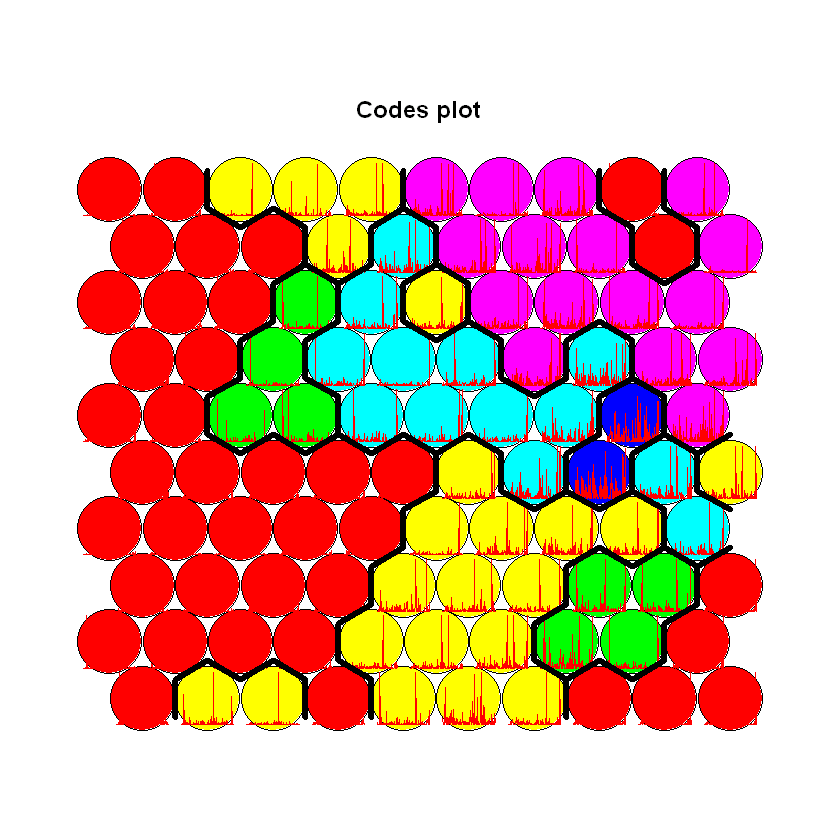

In [11]:
# Wizualizacja klastrów na mapie SOM
plot(groceries_som, type = "codes", bgcol = rainbow(groups)[clusters_groceries])
add.cluster.boundaries(groceries_som, clusters_groceries)

In [12]:
# Przygotowanie zmiennej docelowej dla modelu nadzorowanego:
clusters_target <- factor(clusters_groceries[groceries_som$unit.classif])

In [13]:
##############################################
# Model nadzorowany – metoda xyf z 6 klasami #
##############################################

In [14]:
# Budowa modelu xyf, gdzie jako zmienną docelową (target) podajemy clusters_target
groceries_som_xyf <- xyf(groceries_matrix, clusters_target, 
                         grid = groceries_grid, rlen = 100, alpha = c(0.05, 0.01))
summary(groceries_som_xyf)

SOM of size 10x10 with a hexagonal topology and a bubble neighbourhood function.
The number of data layers is 2.
Distance measure(s) used: sumofsquares, tanimoto.
Training data included: 9835 objects.
Mean distance to the closest unit in the map: 0.072.


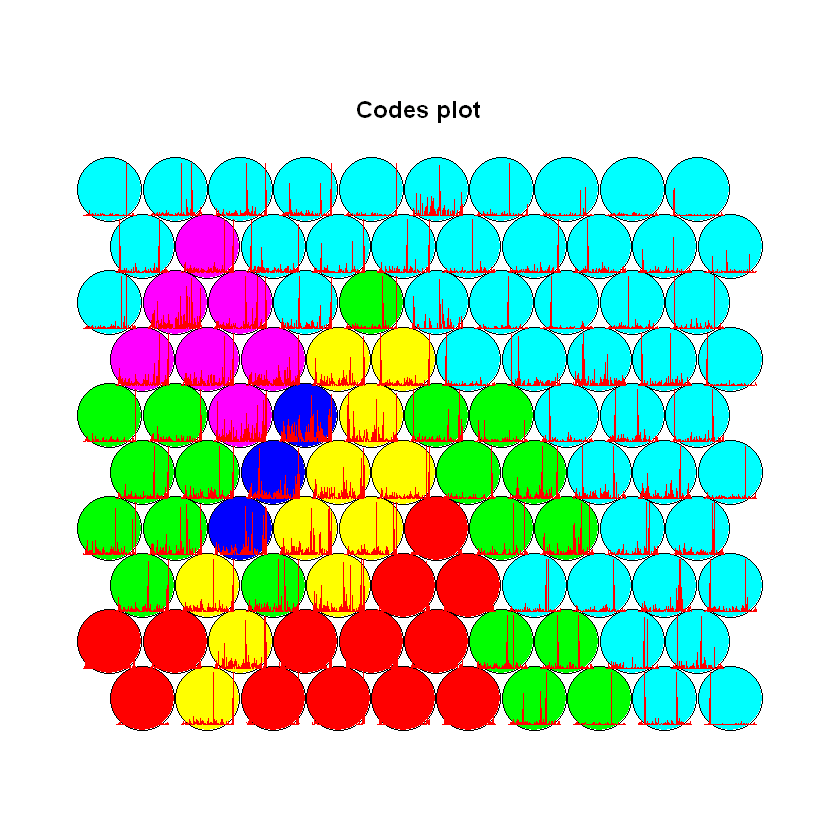

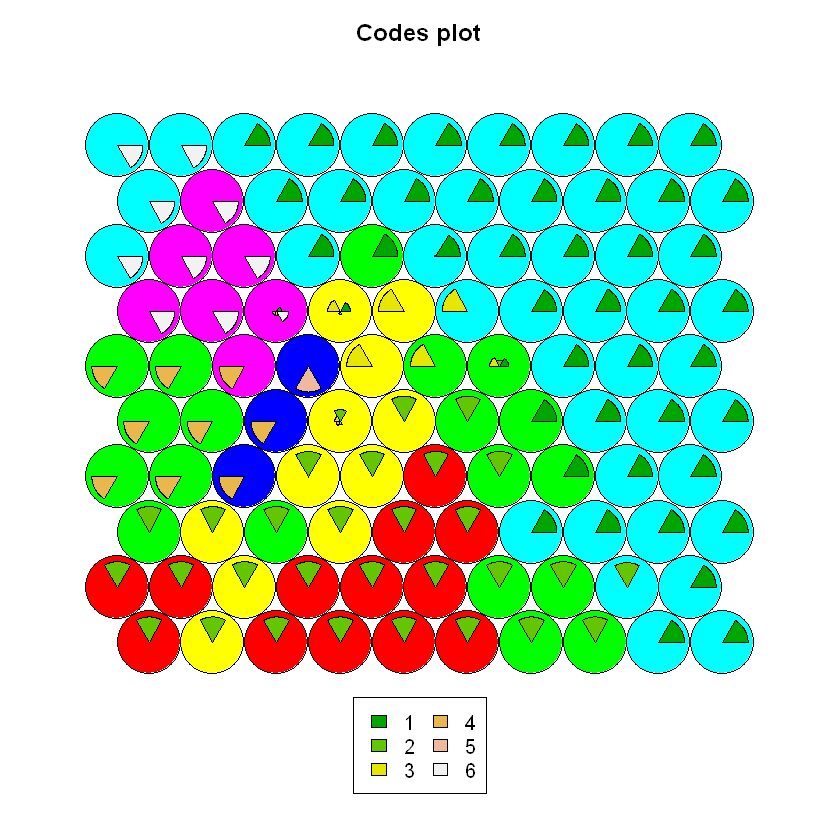

In [15]:
# Dla wizualizacji: klasteryzacja kodów uzyskanych w modelu xyf
hc_xyf <- hclust(dist(groceries_som_xyf$codes[[1]]))
clusters_xyf <- cutree(hc_xyf, k = groups)
plot(groceries_som_xyf, type = "codes", bgcol = rainbow(groups)[clusters_xyf])

In [16]:
# Predykcja i porównanie wyników
pred_xyf <- predict(groceries_som_xyf)
table(clusters_target, factor(pred_xyf$predictions[[2]]))

               
clusters_target    1    2    3    4    5    6
              1 5074    0    0    0    0    0
              2    0 2177    0    0    0    0
              3    0    0  528    0    0    0
              4    0    0    0  807    0    0
              5    0    0    0    0   45    0
              6    0    0    0    0    0 1204

In [17]:
###################################################
# Model nadzorowany – metoda supersom z 6 klasami #
###################################################

In [18]:
# Przygotowanie listy danych: pierwszy element – predyktory, drugi – zmienna docelowa
groceries_matrix_list <- list(groceries_matrix, clusters_target)

In [19]:
# Budowa modelu nadzorowanego supersom
groceries_som_sup <- supersom(groceries_matrix_list, grid = groceries_grid, 
                              rlen = 100, alpha = c(0.05, 0.01))
summary(groceries_som_sup)

SOM of size 10x10 with a hexagonal topology and a bubble neighbourhood function.
The number of data layers is 2.
Distance measure(s) used: sumofsquares, tanimoto.
Training data included: 9835 objects.
Mean distance to the closest unit in the map: 0.08.


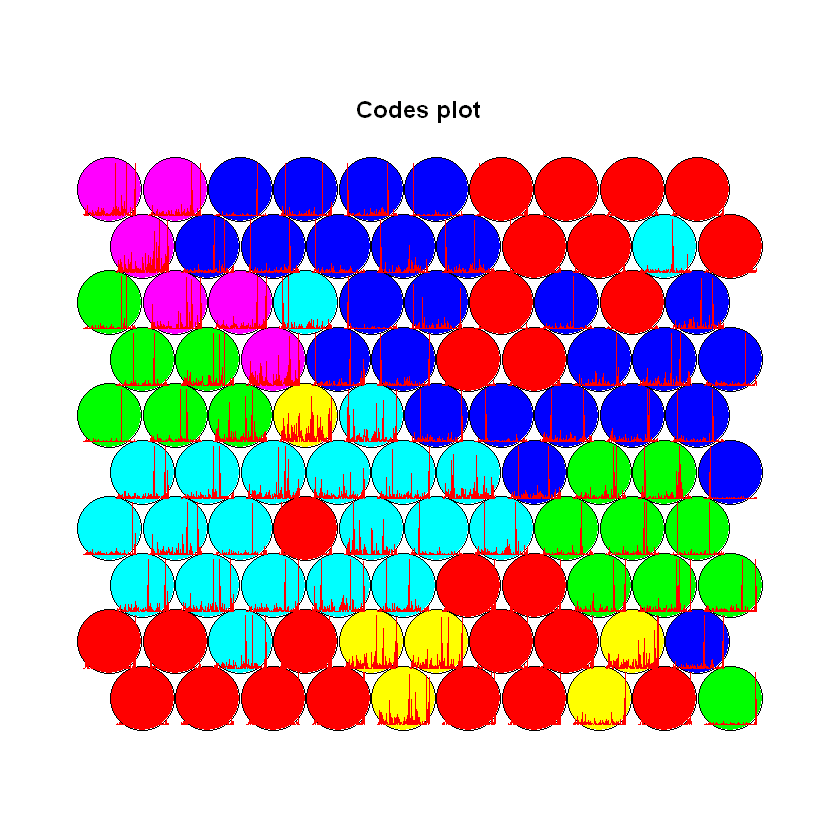

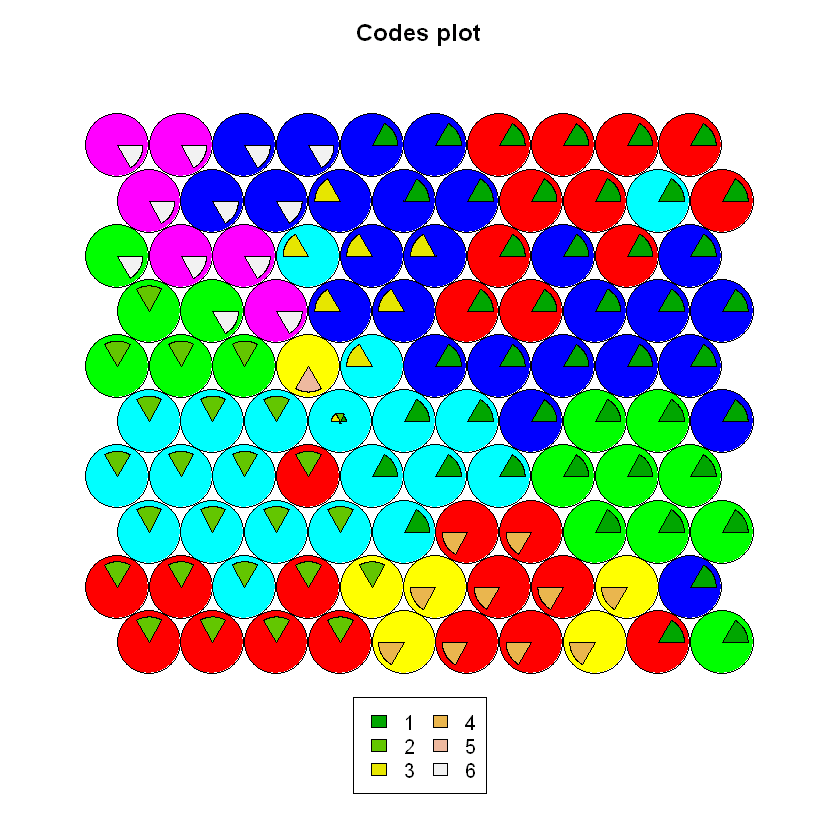

In [20]:
# Klasteryzacja kodów dla modelu supersom (dla wizualizacji)
hc_sup <- hclust(dist(groceries_som_sup$codes[[1]]))
clusters_sup <- cutree(hc_sup, k = groups)
plot(groceries_som_sup, type = "codes", bgcol = rainbow(groups)[clusters_sup])

In [21]:
# Predykcja i porównanie wyników
pred_sup <- predict(groceries_som_sup)
table(clusters_target, factor(pred_sup$predictions[[2]]))

               
clusters_target    1    2    3    4    5    6
              1 5074    0    0    0    0    0
              2    0 2177    0    0    0    0
              3    0    0  528    0    0    0
              4    0    0    0  807    0    0
              5    0    0    0    0   45    0
              6    0    0    0    0    0 1204

In [22]:
#############################################################
# Model nadzorowany przy podziale na zbiór uczący i testowy #
#############################################################

In [23]:
# Podział danych na zbiór uczący (70%) i testowy (30%)
idx_n <- sample(1:nrow(groceries_matrix), size = round(0.7 * nrow(groceries_matrix)))
train <- groceries_matrix[idx_n, ]
test  <- groceries_matrix[-idx_n, ]

In [24]:
# Dla zbioru uczącego wybieramy kolumny o niezerowej wariancji
nonzero_cols <- apply(train, 2, function(x) sd(x) > 0)
train_nonzero <- train[, nonzero_cols]

In [25]:
# Standaryzacja danych uczących
train_sc <- scale(train_nonzero)

In [26]:
# Definiowanie mniejszej siatki SOM (np. 5x5)
som_grid_small <- somgrid(xdim = 5, ydim = 5, topo = "hexagonal")

In [27]:
# Uczenie niesuperwizowanego SOM na zbiorze uczącym
som_groceries_train <- som(train_sc, grid = som_grid_small, 
                           rlen = 200, alpha = c(0.05, 0.01), keep.data = TRUE)

In [28]:
# Klasteryzacja kodów – ustalamy 6 klastrów
set_cluster <- 6
som_groceries_hc_train <- cutree(hclust(dist(som_groceries_train$codes[[1]])), set_cluster)
train_cluster <- factor(som_groceries_hc_train[som_groceries_train$unit.classif])
if (length(unique(train_cluster)) < 6) {
  warning("train_cluster ma mniej niż 6 poziomów. Losowo przypisujemy etykiety.")
  train_cluster <- factor(sample(1:set_cluster, size = length(train_cluster), replace = TRUE))
}

In [29]:
# Konwersja etykiet do macierzy zero‐jedynkowej (one-hot encoding)
y_dummy <- model.matrix(~ train_cluster - 1)
y_dummy <- y_dummy[, apply(y_dummy, 2, function(col) length(unique(col)) > 1), drop = FALSE]
sd_y <- apply(y_dummy, 2, sd)
if(any(sd_y < 1e-8)) {
  cat("Dodajemy szum do warstwy etykiet...\n")
  y_dummy <- y_dummy + matrix(rnorm(nrow(y_dummy)*ncol(y_dummy), sd = 1e-6), nrow = nrow(y_dummy))
}

In [30]:
# Przygotowanie danych do modelu nadzorowanego (supersom)
train_l_sc <- list(x = train_sc, y = y_dummy)
mygrid <- somgrid(xdim = 5, ydim = 5, topo = "hexagonal")
som_groceries_l <- supersom(train_l_sc, grid = mygrid, maxNA.fraction = 0.5,
                            dist.fcts = list(x = "euclidean", y = "euclidean"))

In [31]:
# Przygotowanie zbioru testowego – wybieramy te same kolumny co w zbiorze treningowym
test_nonzero <- test[, nonzero_cols]
test_sc <- scale(test_nonzero)
test_l_sc <- list(x = as.matrix(test_sc))

In [32]:
# Predykcja dla zbioru testowego
test_pred <- predict(som_groceries_l, newdata = test_l_sc)

In [33]:
# Tworzenie data.frame z przypisanymi etykietami
train_final <- data.frame(train, cluster = train_cluster)
test_final  <- data.frame(test, cluster = test_pred$predictions$y)
by(train_final, train_final$cluster, summary)
by(test_final, test_final$cluster, summary)

train_final$cluster: 1
 abrasive.cleaner   artif..sweetener   baby.cosmetics        baby.food
 Min.   :0.000000   Min.   :0.000000   Min.   :0.0000000   Min.   :0  
 1st Qu.:0.000000   1st Qu.:0.000000   1st Qu.:0.0000000   1st Qu.:0  
 Median :0.000000   Median :0.000000   Median :0.0000000   Median :0  
 Mean   :0.004044   Mean   :0.002546   Mean   :0.0002995   Mean   :0  
 3rd Qu.:0.000000   3rd Qu.:0.000000   3rd Qu.:0.0000000   3rd Qu.:0  
 Max.   :1.000000   Max.   :1.000000   Max.   :1.0000000   Max.   :0  
      bags           baking.powder     bathroom.cleaner        beef        
 Min.   :0.0000000   Min.   :0.00000   Min.   :0.000000   Min.   :0.00000  
 1st Qu.:0.0000000   1st Qu.:0.00000   1st Qu.:0.000000   1st Qu.:0.00000  
 Median :0.0000000   Median :0.00000   Median :0.000000   Median :0.00000  
 Mean   :0.0001498   Mean   :0.01603   Mean   :0.003145   Mean   :0.05212  
 3rd Qu.:0.0000000   3rd Qu.:0.00000   3rd Qu.:0.000000   3rd Qu.:0.00000  
 Max.   :1.0000000   Max

test_final$cluster: train_cluster1
 abrasive.cleaner   artif..sweetener   baby.cosmetics   baby.food
 Min.   :0.000000   Min.   :0.000000   Min.   :0      Min.   :0  
 1st Qu.:0.000000   1st Qu.:0.000000   1st Qu.:0      1st Qu.:0  
 Median :0.000000   Median :0.000000   Median :0      Median :0  
 Mean   :0.002642   Mean   :0.004152   Mean   :0      Mean   :0  
 3rd Qu.:0.000000   3rd Qu.:0.000000   3rd Qu.:0      3rd Qu.:0  
 Max.   :1.000000   Max.   :1.000000   Max.   :0      Max.   :0  
      bags          baking.powder     bathroom.cleaner        beef        
 Min.   :0.000000   Min.   :0.00000   Min.   :0.000000   Min.   :0.00000  
 1st Qu.:0.000000   1st Qu.:0.00000   1st Qu.:0.000000   1st Qu.:0.00000  
 Median :0.000000   Median :0.00000   Median :0.000000   Median :0.00000  
 Mean   :0.000755   Mean   :0.01472   Mean   :0.002265   Mean   :0.04945  
 3rd Qu.:0.000000   3rd Qu.:0.00000   3rd Qu.:0.000000   3rd Qu.:0.00000  
 Max.   :1.000000   Max.   :1.00000   Max.   :1.00000

In [ ]:
# Analiza wykresów i wnioski:

# plot(groceries_som, type = "changes")
# Błąd maleje wraz z interacjami, widać, że sieć skutecznie uczy się na danych

# plot(groceries_som, type = "count")
# Próbki do neuronów są dość równomiernie rozmieszczone (z miejscowymi niedoborami), oznacza to, że sieć dobrze wykorzystuje swoją przestrzeń

# plot(groceries_som, type = "mapping")
# Widać neurony o dużym ugrupowaniu, rozkład nie wskazuje na to, że ma zbyt wiele neuronów

# plot(groceries_som, type = "dist.neighbours")
# Rozmieszczenie jest dość równe, z wykresu nie wynikają wyraźne grupy danych

# plot(groceries_som, type = "codes")
# Wartości sąsiednie są do siebie, co wskazuje na spójność klastra

# plot(groceries_som, type = "codes", bgcol = rainbow(groups)[clusters_groceries])
# add.cluster.boundaries(groceries_som, clusters_groceries)
# Widać jak model klasteryzuje i klasyfikuje neurony

# plot(groceries_som_sup, type = "codes", bgcol = rainbow(groups)[clusters_sup])
# Widać błędy klastrów i to jakie mają inne wartości spoza klastra